In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


1. Parámetros globales

In [19]:
SIMBOLOS    = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
TAM_VENT    = 30
BATCH_SIZE  = 32
EPOCHS      = 50
VAL_SPLIT   = 0.2
TRAIN_RATIO = 0.8   # 80% train, 20% test

2. Descarga y preprocesado de datos



In [20]:
def descargar_datos(simbolos, inicio, fin):
    dfs = []
    for sym in simbolos:
        df = yf.download(sym, start=inicio, end=fin, interval='1d')[['Close']]
        dfs.append(df.rename(columns={'Close': sym}))
    data = pd.concat(dfs, axis=1).dropna().sort_index()
    return data

def normalizar(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    return scaled, pd.DataFrame(scaled, index=df.index, columns=df.columns)

3. Preparar ventanas X,y

In [21]:
def preparar_data(array_2d, tam_vent):
    X, y = [], []
    for i in range(len(array_2d) - tam_vent):
        X.append(array_2d[i:i + tam_vent])
        y.append(array_2d[i + tam_vent])
    return np.array(X), np.array(y)


 4. Definición de los modelos

In [22]:
def crear_lstm_univariado():
    m = Sequential([
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

def crear_lstm_multivariado( n_simbolos):
    m = Sequential([
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(n_simbolos, activation='linear')
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

5. Entrenamiento de modelos

In [23]:
def entrenar_individuales(scaled_df):
    preds = {}
    for sym in SIMBOLOS:
        serie = scaled_df[[sym]].values
        X, y = preparar_data(serie, TAM_VENT)
        model = crear_lstm_univariado()
        model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  validation_split=VAL_SPLIT, verbose=0)
        preds[sym] = model.predict(X).flatten()
    return preds

def entrenar_multivariado(scaled):
    Xm, ym = preparar_data(scaled, TAM_VENT)
    model = crear_lstm_multivariado(len(SIMBOLOS))
    model.fit(Xm, ym, epochs=EPOCHS, batch_size=BATCH_SIZE,
              validation_split=VAL_SPLIT, verbose=0)
    preds = model.predict(Xm)
    return model, preds

6. Cálculo de métricas

In [24]:
def calcular_metricas(real, pred_i, pred_m):
    return {
        'RMSE_Ind': np.sqrt(mean_squared_error(real, pred_i)),
        'MAE_Ind' : mean_absolute_error(real, pred_i),
        'R2_Ind'  : r2_score(real, pred_i),
        'RMSE_Mul': np.sqrt(mean_squared_error(real, pred_m)),
        'MAE_Mul' : mean_absolute_error(real, pred_m),
        'R2_Mul'  : r2_score(real, pred_m),
    }

7. Evaluación solo en test

In [25]:
def evaluar_en_test(scaled, preds_ind, preds_mul):
    split = int(len(scaled) * TRAIN_RATIO)
    start = split - TAM_VENT
    resultados = []
    for idx, sym in enumerate(SIMBOLOS):
        # datos test univariado
        serie = scaled[:, idx:idx+1]
        Xti, yti = preparar_data(serie[start:], TAM_VENT)
        pred_i = preds_ind[sym][start:]
        # datos test multivariado
        Xm, ym = preparar_data(scaled[start:], TAM_VENT)
        pred_m = preds_mul[start:, idx]
        # métricas
        m = calcular_metricas(yti, pred_i, pred_m)
        m['Símbolo'] = sym
        resultados.append(m)
    return pd.DataFrame(resultados), split, start

8. Plot de test

In [26]:
def plot_solo_test(index, real_offset, preds_ind, preds_mul, split, start):
    fechas_test = index[split:]
    fig, axs = plt.subplots(len(SIMBOLOS), 1, figsize=(10, 4*len(SIMBOLOS)))
    for ax, sym in zip(axs, SIMBOLOS):
        i = SIMBOLOS.index(sym)
        rt = real_offset[start:, i]
        pi = preds_ind[sym][start:]
        pm = preds_mul[start:, i]

        ax.plot(fechas_test, rt, label='Real', linewidth=2)
        ax.plot(fechas_test, pi, label='Individual', linestyle='--')
        ax.plot(fechas_test, pm, label='Multivariado', linestyle=':')
        ax.set_title(sym)
        ax.legend()
        ax.set_ylabel('Valor normalizado')

    axs[-1].set_xlabel('Fecha')
    plt.tight_layout()
    plt.show()




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

=== Métricas en train+test ===
 RMSE_Ind  MAE_Ind   R2_Ind  RMSE_Mul  MAE_Mul   R2_Mul Símbolo
 0.040279 0.030250 0.970200  0.051299 0.040715 0.951662    AAPL
 0.037109 0.029766 0.981241  0.039783 0.031545 0.978440    MSFT
 0.034016 0.026387 0.981846  0.048510 0.040129 0.963081   GOOGL
 0.039862 0.030972 0.976358  0.044057 0.033623 0.971121    AMZN

=== Métricas solo en test ===
 RMSE_Ind  MAE_Ind   R2_Ind  RMSE_Mul  MAE_Mul   R2_Mul Símbolo
 0.059606 0.044416 0.812847  0.071937 0.058966 0.727406    AAPL
 0.050358 0.040719 0.775947  0.054978 0.044839 0.732958    MSFT
 0.046120 0.038388 0.846669  0.062147 0.052308 0.721584   GOOGL
 0.057904 0.047689 0.711701  0.065972 0.054776 0.625768    AMZN


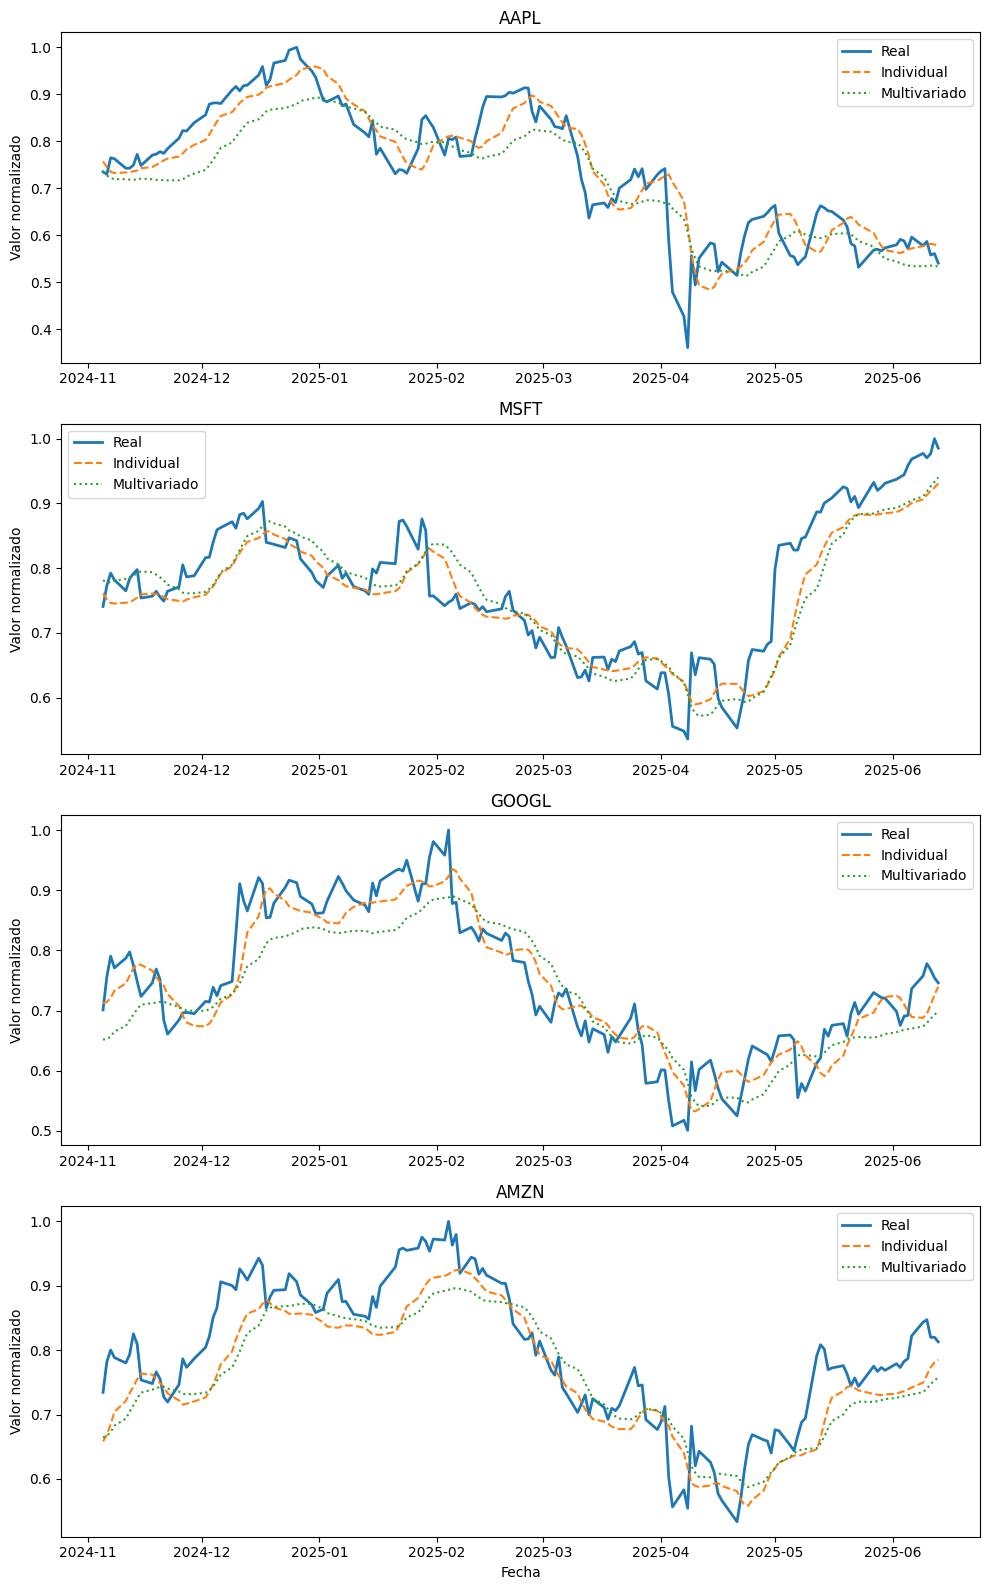

In [28]:
# Fechas y datos
hoy  = dt.date.today()
hace = hoy - dt.timedelta(days=3*365)
df   = descargar_datos(SIMBOLOS, hace, hoy)
scaled, scaled_df = normalizar(df)

# Entrenar modelos
preds_ind = entrenar_individuales(scaled_df)
model_mul, preds_mul = entrenar_multivariado(scaled)

# Métricas globales (train+test)
real_off = scaled[TAM_VENT:]
metrics = []
for idx, sym in enumerate(SIMBOLOS):
    m = calcular_metricas(real_off[:,idx], preds_ind[sym], preds_mul[:,idx])
    m['Símbolo'] = sym
    metrics.append(m)
print('\n=== Métricas en train+test ===')
print(pd.DataFrame(metrics).to_string(index=False))

# Métricas solo test + ploteo
df_test, split, start = evaluar_en_test(scaled, preds_ind, preds_mul)
print('\n=== Métricas solo en test ===')
print(df_test.to_string(index=False))

plot_solo_test(df.index, real_off, preds_ind, preds_mul, split, start)